# BIAS CORRECTION OF DECADAL PREDICTIONS: Application to the ensemble of predictions

## Tools for accessing and processing climate data: Case study with R


------------

This worked example uses R packages from the  climate4R framework, see the article ["climate4R: An R-based Framework for Climate Data Access, Post-processing and Bias adjustment"](https://www.sciencedirect.com/science/article/pii/S1364815218303049).

![c4R](https://github.com/SantanderMetGroup/climate4R/blob/devel/man/figures/climate4R_2.png?raw=true)

In [1]:
options(java.parameters = "-Xmx8g")

---
**Note that the `suppressMessages` command is utilized throughout the notebook to prevent lengthy output messages. Omitting this command does not affect the generated results.*

***Refer to the "Bias_adjustment_with_climate4R" notebook for the first introduction to the various functions used in this notebook.**

-----

## Parameter setting

Here you can set a few parameters to change the notebook behaviour

### General parameters

Select **city** from the following options: "Barcelona", "Bergen", "Paris", "Prague".

Select the **variable**.

Specify the **factor** with which to **upscale** the observational grid.

Indicate the **paths** to the folders containing the **input data**, the **output data**, and the generated **figures**.

In [2]:
city <- "Paris" 
variable <- "tas"
obs.upscaling.factor <- 4

### Permanent paths

In [3]:
rootdir <- "/home/jovyan"
workdir <- file.path(rootdir, "work")

### Custom paths

Indicate the **paths** to the folders containing the **input data**, the **output data**, and the generated **figures**.

In [4]:
work.folder <- "Bias_adjustment_of_decadal_predictions_with_climate4R"
ncml.dir.obs <- file.path(workdir, "ncml", 'CERRA')
ncml.dir.pred <- file.path(workdir, "ncml", 'EC-Earth3')
output.dir <- file.path(workdir, work.folder, "output")
fig.dir <- file.path(workdir, work.folder, "figures")

### Bias adjustment parameters

Change or keep or add or remove parameters within the list named `bc.args`. These parameters are passed to the `biasCorrection` function later on, so the same parameter names defined by this function are used to build the `bc.args` list. Please check the documentation of the `biasCorrection` function for further parametrization options and documentation. To do so, run `help(biasCorrection)` in a new code chunk.


In [5]:
bc.args <- list(
    # Bias correction method. Options are: "delta", "scaling", "eqm", "pqm", "gpqm", "loci", "dqm", "qdm", "isimip3"
    method = "eqm",
    # Scaling type (only used for method = "scaling")
    scaling.type = "additive",  # or "multiplicative"
    # Moving window width used to calibrate and the target days
    window = c(30, 30),
    # Arguments used if the method is parametric (i.e. method = "pqm")
    fitdistr.args = list(densfun = "normal"),
    # Set the precipitation parameter as TRUE if the variable being corrected is precipitation, and change the default wet threshold if desired.
    precipitation = FALSE,
    wet.threshold = 1,
    # Define the following parameters to apply the bias correction funtion in cross-validation mode
    cross.val = "none", # or "loo", or "kfold"
    folds = NULL, # or the list of year-periods defining the folds
    # Extrapolation 
    extrapolation = "constant", # or "none"
    join.members = TRUE
)

### Metadata

The following metadata definition should align with the 'CORDEX experiment design and archiving specifications for statistical downscaling of CMIP6.' It is used to define the global attributes of the bias-adjusted data and to build the output NetCDF filename later on. Further metadata is defined in section 2. 

In [6]:
dataset <- "dcppA-hindcast"
model <- "EC-Earth"
run <- "r1i4p1f1" 
project_id <- "I4C"
activity_id <- "ESD"
source_type <- "ESD-MOS"
institution_id <- "CSIC"
esd_version <- "v1-r1"
esd_configuration_id <- "C1Cu"
time_scale <- "day"
url <- "https://doi.org/10.1002/joc.5462"

-----

## 1. Library loading

In [7]:
library(loadeR)
library(loadeR.2nc)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(magrittr)
library(geoprocessoR)
library(sp)
library(repr)
options(repr.plot.width=10, repr.plot.height=4)

Loading required package: rJava

Loading required package: loadeR.java

Java version 22x amd64 by N/A detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.1 (2023-06-22) is loaded


Get the latest stable version (1.8.2) using <devtools::install_github(c('SantanderMetGroup/climate4R.UDG','SantanderMetGroup/loadeR'))>

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.3) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.

downscaleR version 3.3.4 (2023-06-22) is loaded

Please use 'citation("downscaleR")' to cite this package.

Please note that rgdal will be retired during October 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-7, (SVN revision 1203)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.8.5, released 2024/04/02
Path to GDAL shared files: /opt/conda/envs/climate4r/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Lo

## 2. Initial setups

Definition of the geographical boundaries of each demonstrator:

In [8]:
domain <- switch(city,
  Barcelona = list(latLim = c(39, 44), lonLim = c(-1, 4)),
  Bergen = list(latLim = c(58, 63), lonLim = c(4, 9)),
  Paris = list(latLim = c(46.5, 51.5), lonLim = c(-1, 4.5)),
  Prague = list(latLim = c(47.5, 52.5), lonLim = c(12, 17))
)
city.centre <- switch(city,
  Barcelona = data.frame(x = 2.2, y = 41.4),
  Bergen = data.frame(x = 5.3, y = 60.4),
  Paris = data.frame(x = 2.3, y = 48.8),
  Prague = data.frame(x = 14.4, y = 50.1)
)

In the following code chunk, the **paths** indicated in the **general parameters** section are created if they do not already exist.

In [9]:
for (d in c(output.dir, fig.dir))
    if (! dir.exists(d))
        dir.create(d, recursive = TRUE)

Definition of the base name used to save the intermediate R data objects:

In [10]:
base.filename <- paste0(output.dir, "/", c(city, variable, bc.args$method) %>% paste(collapse = "_")) %>% print

[1] "/home/jovyan/work/Bias_adjustment_of_decadal_predictions_with_climate4R/output/Paris_tas_eqm"


Finally, an additional set of attributes is defined according to the "CORDEX experiment design and archiving specifications for statistical
downscaling of CMIP6":

In [11]:
esd_method_id <- toupper(bc.args$method)
training_id <- paste0(esd_configuration_id, obs.upscaling.factor)
source_id <- paste0(esd_method_id, "-", training_id) 
esd_method <- sprintf("Bias adjustment of variable %s using the %s method",  
                      variable, esd_method_id)
param.metadata <- paste0(names(bc.args), "=", bc.args) %>% paste(collapse = " ")
training <- sprintf("Adjusted to %s upscaled %s times, applying the `biasCorrection` function from the `downscaleR` package, using the following parameters -> %s",
                    "CERRA", obs.upscaling.factor, param.metadata) 
domain_id <- paste0(toupper(city), "-25")

## 3. Data loading and basic visualization

In this notebook, we use "Datasets" to refer to the NcML files linking and joining the NetCDF files comprising a dataset. 
Climate datasets are typically stored as a collection of separate NetCDF files, each covering different periods, variables, etc. 
NcML files provide a single access point, significantly easing data access by decoupling the logical structure of the files. 

We have previously created the NcML files for this experiment using the `NcML_creation_with_climate4R.ipynb` notebook. In the next chunk, the NcML files of the EC-Earth3 DCPP hindcast are listed and assigned to the `datasets` object. In this case, each *.ncml* file points to a particular initialization year and variable (surface temperature in this case).

In [12]:
datasets <- list.files(ncml.dir.pred, full.names = T, recursive = T, pattern = paste0(variable, ".*.ncml"))
datasets %>% head

[1] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1960-r1i4p1f1_day_tas_gr_v20220322.ncml"
[2] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1961-r1i4p1f1_day_tas_gr_v20220322.ncml"
[3] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1962-r1i4p1f1_day_tas_gr_v20220322.ncml"
[4] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1963-r1i4p1f1_day_tas_gr_v20220322.ncml"
[5] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1964-r1i4p1f1_day_tas_gr_v20220322.ncml"
[6] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1965-r1i4p1f1_day_tas_gr_v20220322.ncml"

Discard initializations before 1974 due to the lack of observational data before 1984.

In [13]:
datasets <- datasets[(datasets %>% grep(pattern = "1974")) : length(datasets)] %<>% print

 [1] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1974-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [2] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1975-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [3] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1976-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [4] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1977-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [5] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1978-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [6] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1979-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [7] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1980-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [8] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1981-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [9] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1982-r1i4p1f1_day_tas_gr_v20220322.ncml"
[10] "/home/jovyan/work/ncml/EC-Earth3/dcppA-hindcast/s1983-r1i4p1f1_day_tas_gr_v20220322.ncml"
[11] "/home/jovyan/work/ncml/EC-Earth3/d

Next the observational dataset is defined as `dataset.obs`. In this case corresponds to a single NcML file pointing to the `tas` variable of the CERRA reanalysis.

In [14]:
dataset.obs <- list.files(ncml.dir.obs, full.names = T) 
dataset.obs

[1] "/home/jovyan/work/ncml/CERRA/tas_f3h-r2631x1113.ncml"

### 3.1. Data loading of the observational reference


The observational reference grid is high resolution, therefore, it is a common practice to perform an upscaling to avoid a big resolution mismatch. For efficiency, here  data loading (`loadGridData` function) is performed year by year (`1984-2004` period) in a `lapply` loop and upscaled (`upscaleGrid`) in each iteration. This operation takes a few minutes. To save time, if the resulting object already exists as a saved `rds` file (`cache.file`) due to the previous execution of this code chunk, the operation is not repeated, and the `rds` file is loaded instead. This operation takes a few minutes.

In [15]:
cache.file <- paste0(base.filename, "_city.obs.long.rds")

if (!file.exists(cache.file)) {
    
    city.obs <- lapply(1984:2004, function(y) {
        message("Loading and upscaling year...", y)
        loadGridData(dataset.obs, 
                     var = variable, 
                     latLim = domain$latLim,
                     lonLim = domain$lonLim, 
                     years = y) %>%
        upscaleGrid(times = obs.upscaling.factor, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
        redim(drop = TRUE) %>% suppressMessages
    })

    saveRDS(city.obs, cache.file)

} else {

    message("Reading from cache.")
    city.obs <- readRDS(cache.file)
    
}

Loading and upscaling year...1984

Loading and upscaling year...1985

Loading and upscaling year...1986

Loading and upscaling year...1987

Loading and upscaling year...1988

Loading and upscaling year...1989

Loading and upscaling year...1990

Loading and upscaling year...1991

Loading and upscaling year...1992

Loading and upscaling year...1993

Loading and upscaling year...1994

Loading and upscaling year...1995

Loading and upscaling year...1996

Loading and upscaling year...1997

Loading and upscaling year...1998

Loading and upscaling year...1999

Loading and upscaling year...2000

Loading and upscaling year...2001

Loading and upscaling year...2002

Loading and upscaling year...2003

Loading and upscaling year...2004



As the data loading has been performed in a loop of years, the next step is to obtain a single grid from the loaded list of grids, binding them along the time dimension.

In [16]:
city.obs <- bindGrid(city.obs, dimension = "time")

### 3.2. Data loading of decadal predictions and cration of the Multi-member ensemble of 10 lead-years

In the case of decadal predictions, a lead-year is loaded in each iteration (`m`) of the loop. For each lead-year the code iterates over each dataset, where the first year `y` is extracted from the dataset information, and where two loading operations are performed. In the first step, the November and December are loaded from the first year of the corresponding lead-year (`y + m`). In the second step, the subsequent year is loaded (`y + m + 1`) from January to October. The binding of both grids is performed afterward. 

In [17]:
cache.file2 <- paste0(base.filename, "_city.pred.m.rda")

if (!file.exists(cache.file2)) {
    
    city.pred.m <- lapply(0:9, function(m) {
        message("loading lead-year: ", m)
        lapply(datasets, function(d) {
            di <- dataInventory(d) %>% suppressMessages
            y <- di$tas$Dimensions$time$Date_range %>%  substring(first = 1, last = 4) %>% as.numeric 
            g1 <- loadGridData(d, 
                               years = y + m, 
                               season = 11:12,
                               var = variable,  
                               latLim = domain$latLim,
                               lonLim = domain$lonLim) %>% suppressMessages
            g2 <- loadGridData(d, 
                               years = y + m + 1, 
                               season = 1:10,
                               var = variable,  
                               latLim = domain$latLim,
                               lonLim = domain$lonLim) %>% suppressMessages
            bindGrid(g1, g2, dimension = "time") 
        }) %>% c(dimension = "time") %>% do.call(what = "bindGrid")
    })

    saveRDS(city.pred.m, cache.file2)

} else {

    message("Reading from cache.")
    city.pred.m <- readRDS(cache.file2)

}

loading lead-year: 0

loading lead-year: 1

loading lead-year: 2

loading lead-year: 3

loading lead-year: 4

loading lead-year: 5

loading lead-year: 6

loading lead-year: 7

loading lead-year: 8

loading lead-year: 9



Next, a quick examination of the time series of the loaded data is conducted to illustrate the overlapping and non-overlapping time periods. This is done by plotting the time series of the first and last lead years with the function `temporalPlot`.

pad applied on the interval: day

pad applied on the interval: day



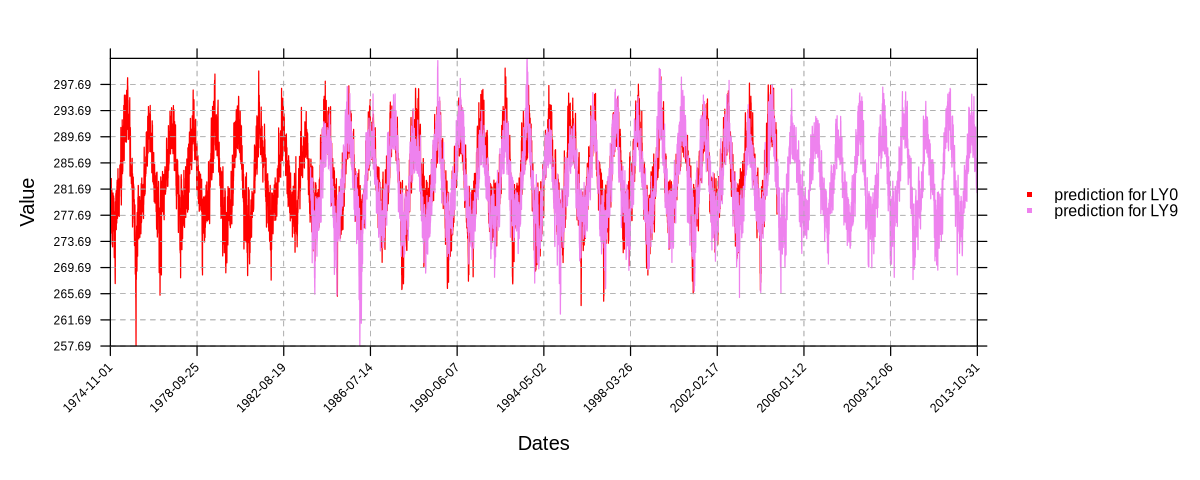

In [18]:
temporalPlot("prediction for LY0" = city.pred.m[[1]], "prediction for LY9" = city.pred.m[[10]], cols = c("red", "violet"))

Next the temporal intersection of the 10 members is performed with `intersectGrid`.

In [19]:
city.pred.m.common <- intersectGrid(city.pred.m[[1]], city.pred.m[[2]], city.pred.m[[3]], city.pred.m[[4]], city.pred.m[[5]], 
                   city.pred.m[[6]], city.pred.m[[7]], city.pred.m[[8]], city.pred.m[[9]], city.pred.m[[10]], 
                   type = "temporal", 
                   which.return = 1:10)

Next, all lead-years are binded along the "member" dimension to create a multi-member grid.

In [20]:
city.pred.ens <- bindGrid(city.pred.m.common, dimension = "member")
str(city.pred.ens$Data)

 num [1:10, 1:7671, 1:8, 1:8] 285 279 280 285 286 ...
 - attr(*, "dimensions")= chr [1:4] "member" "time" "lat" "lon"


The `temporalPlot` function recognizes the member dimension and plots the ensemble mean time series (solid line) and the spread (shadow): 

pad applied on the interval: day



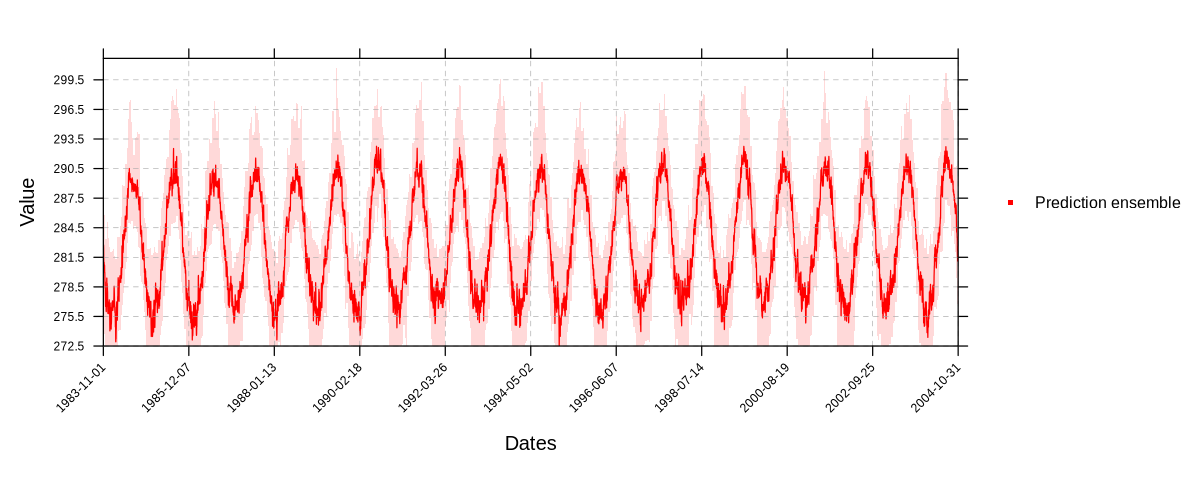

In [21]:
temporalPlot("Prediction ensemble" = city.pred.ens, cols = "red")

Before applying the `biasCorrection` function, the temporal intersection of the observation and the prediction is performed. Although this operation is also done internally by the `biasCorrection` function, it is preferable to perform it beforehand. This allows us to create the intersected grids for later comparison with the bias-adjusted results. The previous time series plot is also repeated, including the observational reference this time.

In [22]:
city.obs <- intersectGrid(city.obs, city.pred.ens, which.return = 1)
city.pred.ens <- intersectGrid(city.obs, city.pred.ens, which.return = 2)

pad applied on the interval: day

pad applied on the interval: day



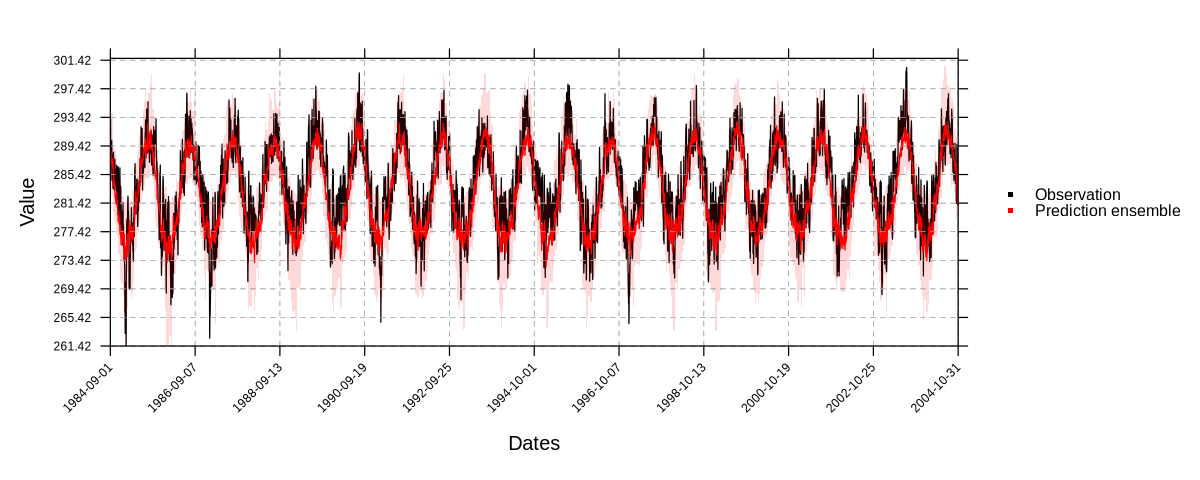

In [23]:
temporalPlot("Observation" = city.obs, "Prediction ensemble" = city.pred.ens)

## 4. Bias adjustment of the multi-member ensemble 

The `biasCorrection` function uses the nearest prediction grid-point to each observational grid-point for correcting the bias. Next, an example of an application is illustrated (no executable), where the joint distribution of all members is considered for bias correction. 

```R
cal.ens <- biasCorrection(y = city.obs, 
                              x = city.pred.ens, 
                              newdata = city.pred.ens, 
                              method = "eqm",
                              join.members = TRUE)
                              
```

To apply the `biasCorrection` function using the parameters set at the beginning of this notebook, define the `x` and `y` slots of the parameter list assigning them the loaded grids. 

In [24]:
bc.args[["y"]] <- city.obs
bc.args[["x"]] <- city.pred.ens

Then the `do.call` function is used as follows.

In [25]:
cache.file3 <- paste0(base.filename, "_cal.ens.rda")

if (!file.exists(cache.file3)) {
    
    cal.ens <- do.call("biasCorrection", bc.args)

    saveRDS(cal.ens, cache.file3)
    
} else {

    message("Reading from cache.")
    cal.ens <- readRDS(cache.file3)

}

[2024-07-18 15:09:10.775068] Trying to determine the time zone...

[2024-07-18 15:09:10.77668] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-07-18 15:09:12.44313] Already complete date record. Nothing was done

[2024-07-18 15:09:12.937896] Trying to determine the time zone...

[2024-07-18 15:09:12.939625] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-07-18 15:09:13.449516] Already complete date record. Nothing was done

[2024-07-18 15:09:13.531308] Trying to determine the time zone...

[2024-07-18 15:09:13.532848] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-07-18 15:09:14.064771] Already complete date record. Nothing was done

[2024-07-18 15:09:27.881228] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-07-18 15:10:15.461902] Window option is currently not supported for joined members and will be

The `biasCorrection` function changes the format of the dates stored in the grid, which can create conflicts when applying other functions to the resulting grid since this aspect of the date format is still under development in the climate4R framework. However, this issue can be easily resolved by converting the dates back to the `character` format:

In [26]:
cal.ens$Dates <- lapply(cal.ens$Dates, as.character)

The `window` option is currently not supported for joined members (`join.members = TRUE`). To use the window option set `join.members = FALSE` (see the next bias correction example below). 

#### Results comparison for the temporal mean

Next, the `spatialPlot` function is used for the map representation. To use this function, it is necessary to apply a temporal aggregation function first, to do so, the `climatology` function is used, which performs the temporal mean by default (use the `clim.fun` parameter to change the aggregation function). Next, the observational reference, and the raw and adjusted predictions are plotted. Note that the `spatialPlot` function also recognizes the member dimension (here the different lead-years).

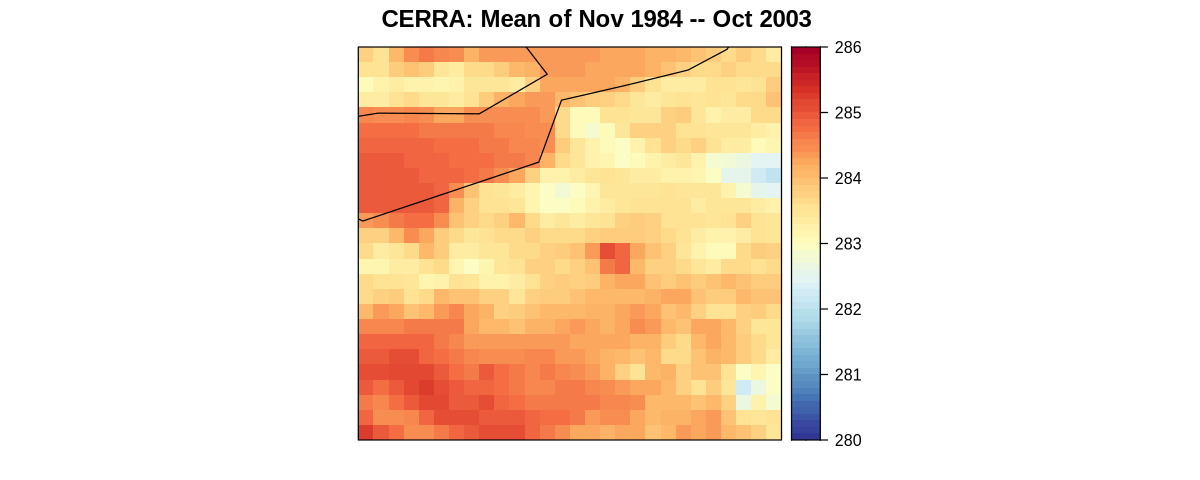

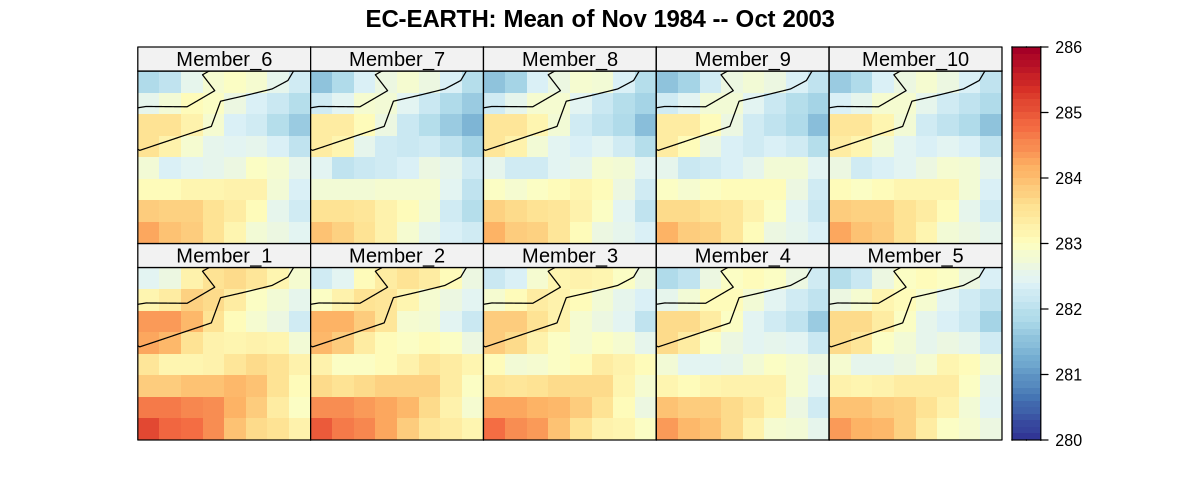

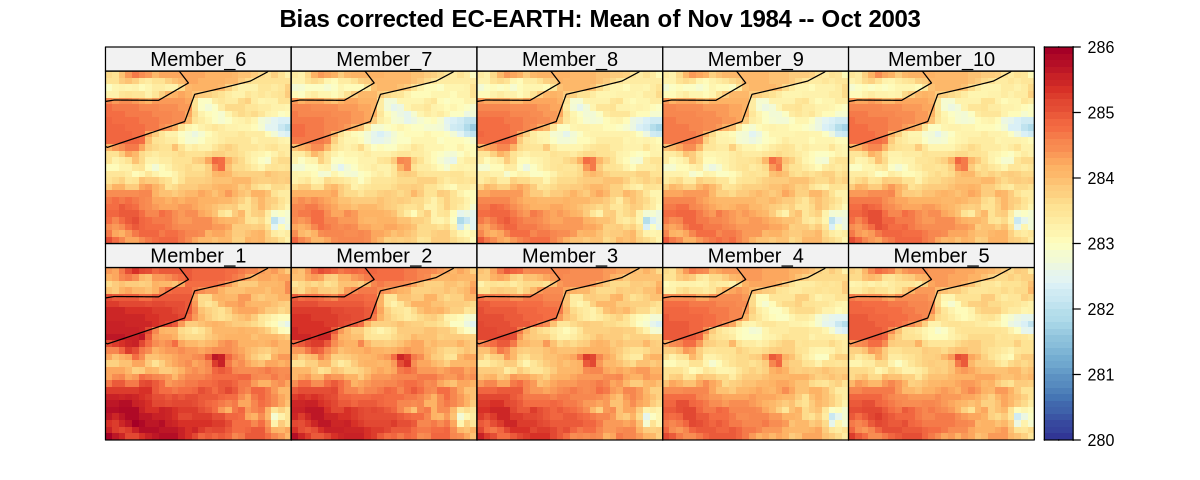

In [27]:
cbar.ticks <- seq(280, 286, 0.1)

spatialPlot(city.obs %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "CERRA: Mean of Nov 1984 -- Oct 2003 ") %>% suppressMessages

spatialPlot(city.pred.ens %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "EC-EARTH: Mean of Nov 1984 -- Oct 2003",
            layout = c(5, 2)) %>% suppressMessages

spatialPlot(cal.ens %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "Bias corrected EC-EARTH: Mean of Nov 1984 -- Oct 2003",
            layout = c(5, 2)) %>% suppressMessages


#### Export figures:
Use `pdf` (or `png`) and `dev.off` to export any figure. For instance, to export the last figure we have generated, do the following:

In [28]:
pdf(file.path(fig.dir, "Bias corrected EC-EARTH Mean of Nov 1984-Oct 2003.pdf"))
    spatialPlot(cal.ens %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "Bias corrected EC-EARTH: Mean of Nov 1984 -- Oct 2003",
            layout = c(5, 2)) %>% suppressMessages
        dev.off()

png 
  2

#### Results comparison for the spatial mean:


<u>Daily time series:<u>

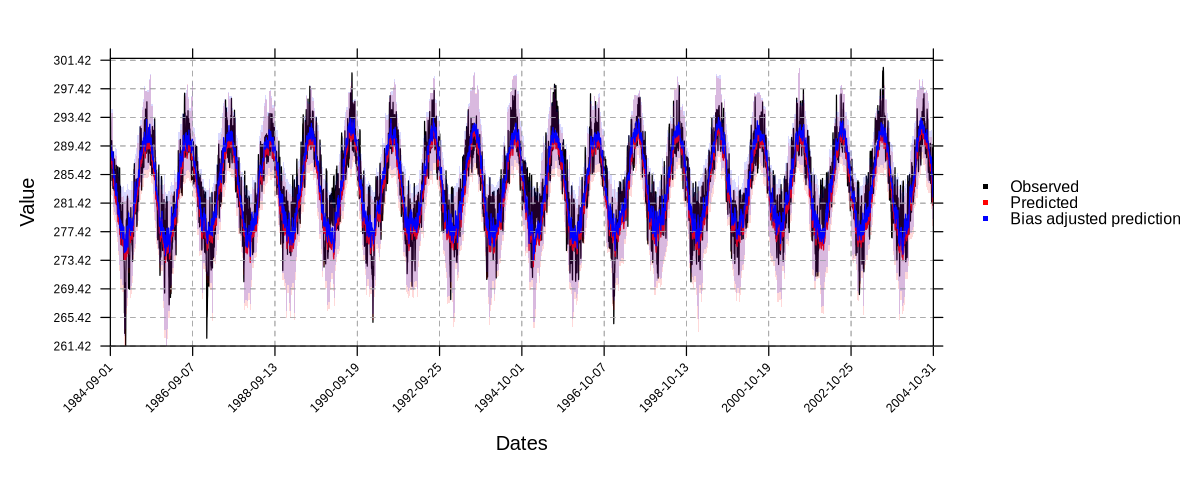

In [29]:
temporalPlot("Observed" = city.obs, 
             "Predicted" = city.pred.ens,  
             "Bias adjusted prediction" = cal.ens) %>% suppressMessages

<u>Annual time series:<u>

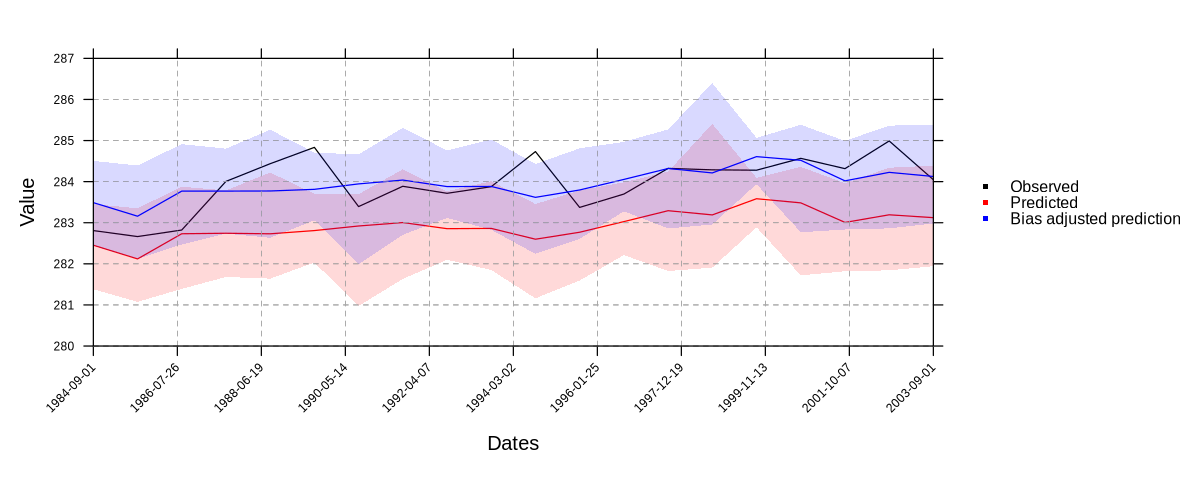

In [30]:
temporalPlot("Observed" = city.obs %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)), 
             "Predicted" = city.pred.ens %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             "Bias adjusted prediction" = cal.ens %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             xyplot.custom = list(ylim = c(280, 287))) %>% suppressMessages

#### Bias correction of each member separately and using the moving window option

Change the parameters `join.members` and check if parameter `window` is already set.

In [31]:
bc.args[["join.members"]] <- FALSE %>% print
bc.args[["window"]] %>% print

[1] FALSE
[1] 30 30


In [32]:
cache.file4 <- paste0(base.filename, "_cal.ens.2.rda")

if (!file.exists(cache.file4)) {
    
    cal.ens.2 <- do.call("biasCorrection", bc.args)

    saveRDS(cal.ens.2, cache.file4)
    
} else {

    message("Reading from cache.")
    cal.ens.2 <- readRDS(cache.file4)

}

[2024-07-18 15:19:22.61976] Trying to determine the time zone...

[2024-07-18 15:19:22.621312] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-07-18 15:19:23.152605] Already complete date record. Nothing was done

[2024-07-18 15:19:23.213649] Trying to determine the time zone...

[2024-07-18 15:19:23.215424] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-07-18 15:19:23.596449] Already complete date record. Nothing was done

[2024-07-18 15:19:23.703496] Trying to determine the time zone...

[2024-07-18 15:19:23.70542] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-07-18 15:19:24.301837] Already complete date record. Nothing was done

[2024-07-18 15:19:34.243116] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-07-18 15:19:42.100263] Number of windows considered: 12...

[2024-07-18 15:19:42.467882] Bias-

The `biasCorrection` function changes the format of the dates stored in the grid, which can create conflicts when applying other functions to the resulting grid since this aspect of the date format is still under development in the climate4R framework. However, this issue can be easily resolved by converting the dates back to the `character` format:

In [33]:
cal.ens.2$Dates <- lapply(cal.ens.2$Dates, as.character)

#### Results comparison for the spatial mean:

<u>Maps of the temporal mean:<u>

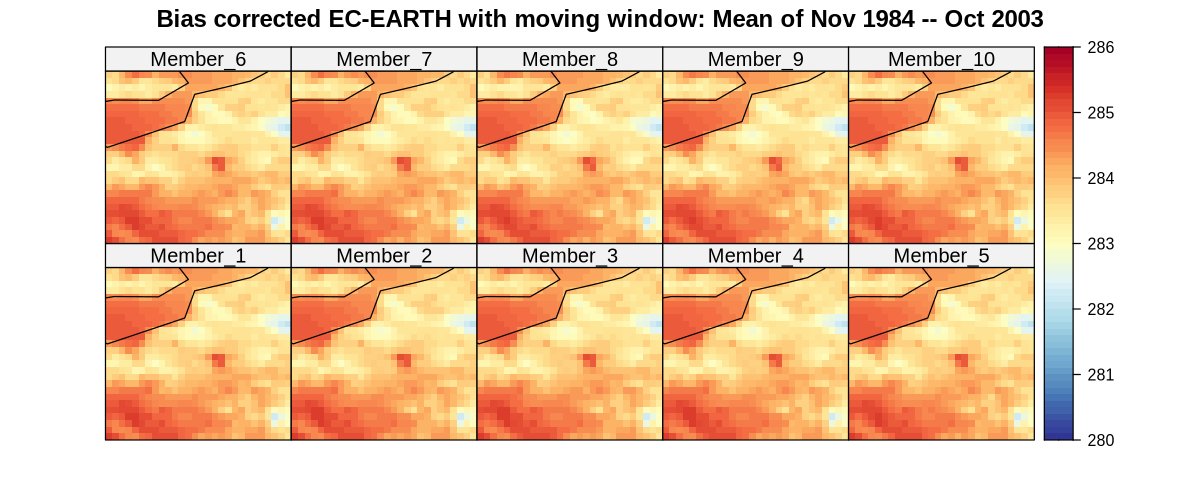

In [34]:
spatialPlot(cal.ens.2 %>% climatology, backdrop.theme = "coastline", at = cbar.ticks, rev.colors = TRUE,
            main = "Bias corrected EC-EARTH with moving window: Mean of Nov 1984 -- Oct 2003",
            layout = c(5, 2)) %>% suppressMessages

<u>Annual time series:<u>

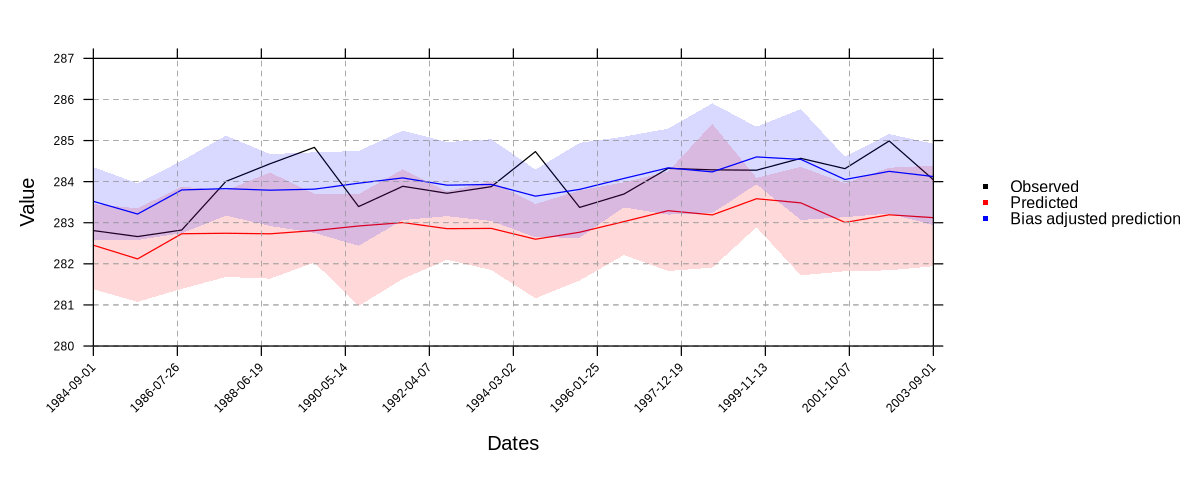

In [35]:
temporalPlot("Observed" = city.obs %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)), 
             "Predicted" = city.pred.ens %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             "Bias adjusted prediction" = cal.ens.2 %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             xyplot.custom = list(ylim = c(280, 287))) %>% suppressMessages

## 5. Export the results

Next, we will write the output obtained in the previous section (`cal.ens.2`) to a NetCDF using the `grid2nc` function. First, add the global attributes that were set up at the beginning of the notebook, and build the output file name (`output.drs`).

In [36]:
attr(cal.ens.2, "project_id") <- project_id
attr(cal.ens.2, "activity_id") <- activity_id
attr(cal.ens.2, "source_type") <- source_type
attr(cal.ens.2, "institution_id") <- institution_id
attr(cal.ens.2, "esd_method_id") <- esd_method_id
attr(cal.ens.2, "training_id") <- training_id
attr(cal.ens.2, "source_id") <- source_id
attr(cal.ens.2, "esd_method") <- esd_method
attr(cal.ens.2, "training") <- training
attr(cal.ens.2, "dataset") <- dataset
attr(cal.ens.2, "further_info_url") <- url

In [37]:
date_range <- range(cal.ens.2$Dates) %>% gsub(pattern = "-", replacement = "") %>% paste(collapse = "-")
output.drs <- paste(variable, domain_id, model, dataset, "ly-ens", run, institution_id, source_id, esd_version, time_scale, date_range, sep = "_")
filename <- paste0(output.drs, ".nc")

In [38]:
grid2nc(cal.ens.2, NetCDFOutFile = paste0(output.dir, "/", filename))

[2024-07-18 15:23:37.550333] NetCDF file written in: /home/jovyan/work/Bias_adjustment_of_decadal_predictions_with_climate4R/output/tas_PARIS-25_EC-Earth_dcppA-hindcast_ly-ens_r1i4p1f1_CSIC_EQM-C1Cu4_v1-r1_day_19840901-20041031.nc

